### CMIP6 Drought Anomaly: Pre & Post processing, Timeseries export


### Required Packages

In [1]:
# data import
import zarr
import intake
from dask.diagnostics import ProgressBar


import numpy as np
import pandas as pd
import xarray as xr
import dask 
import datetime

xr.set_options(display_style='html')
import cftime
import nc_time_axis

import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

### TO DO:
- turn helper functions into a utility package

In [2]:
#import sys
#sys.path.append('~/drought-termination/code/CMIP6_utils.py')
#import CMIP6_utils

### Helper Functions


In [3]:
def fix_lon(ds):
    '''
    adjust longitude to be [-180, 180]
    '''
    ds = ds.copy()
    
    ## TO DO FIGURE OUT HOW TO KEEP LONGITUDE ATTRIBUTES 
    if ds.lon.max()>180:
        ds.coords['lon'] = ((ds.coords['lon'] + 180) % 360 - 180) 
        ds = ds.sortby(ds.lon)

    return ds

def fix_time(ds):
    '''
    reformat time data to be a cftime.datetime object with year, month, day=1, calendar='proleptic_gregorian'
    '''
    ds = ds.copy()
    
    # get time tuples, in the form (year, month, ... )
    time_tuples = [t.timetuple() for t in ds.coords['time'].data]
    #ds.coords['time'] = [cftime.datetime(time_tuple[0], time_tuple[1], 1, calendar='proleptic_gregorian')
    #                     for time_tuple in time_tuples]
    
    ds.coords['time'] = [cftime.datetime(time_tuple[0], time_tuple[1], time_tuple[2], calendar='proleptic_gregorian')
                         for time_tuple in time_tuples]
    
    return ds


def wrapper(ds):
    '''
    clean up newly imported data
    '''
    ds = ds.copy()
    
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
    if ('bnds' in ds.dims): 
        ds=ds.drop_dims('bnds')
    if ('vertex' in ds.dims): 
        ds=ds.drop_dims('vertex')
    if ('height' in ds.dims): 
        ds=ds.drop_dims('height')
    if ('height' in ds): 
        ds=ds.drop_vars('height') 
    if ('depth' in ds.dims):
        ds=ds.drop_dims('depth')
    if ('depth' in ds): 
        ds=ds.drop_vars('depth') 
    
    
    # clean up the different calendars and get them all using the same cftime (hopefully)
    ds = fix_time(ds)
    # fix longitude values across all the models 
    ds = fix_lon(ds)
    return ds



### GLOBAL MEANS ###
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """
    Calculate weighted global mean average
    """
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'} - {'year'} - {'member_id'}
    return (ds * weight).mean(other_dims)

def region_select(ds, region_params):
    """
    subset a dataset by region
    """
    region_ds = ds.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']))
    return region_ds


### ANOMALIES ###

def anomalies(ds, model):
    '''
    Returns timeseries of anomalies (globally averaged) for a given dataset.
    '''
    try:  
        baseline = ds.sel(time = slice('1861', '1880')).groupby('time.month')
        ds_standard = (ds.groupby('time.month') - baseline.mean())/baseline.std()
        ds_anom = global_mean(ds_standard)
        return ds_anom
    except:
        print('***** error calculating ' + str(model) + ' anomalies *****')   

### RESPONSES ###

def responses(ds):
    """
    Calculate difference between early and late period.
    Lazy.
    """

    ds = ds.copy()
    
    early_start = '1861'
    early_end = '1880'
    early = ds.sel(time=slice(early_start, early_end)).mean(dim = 'time')
    
    late_start = '2050'
    late_end = '2100'
    late = ds.sel(time = slice(late_start, late_end)).mean(dim = 'time')
    
    difference = (late - early)/early.std()
    
    return difference

## Variable, Model, Experiment, and Region Selection for Querying pangeo CMIP6 datastore

I've loaded data models that include surface soil moisture (`mrsos`), temperature (`tas`), and precipitation (`pr`) at the monthly timescale (`Amon` for atmospheric variables and `Lmon` for land variables) for the historical time period and future scenario, `ssp585`. This can, of course, be adjusted to look for different variables and scenarios.

I've also loaded data for total column moisture (`mrso`) and precipitation (`pr`). 

For more information on the available data and naming conventions check out [this google doc](https://docs.google.com/document/d/1h0r8RZr_f3-8egBMMh7aqLwy3snpD6_MrDz1q8n5XUk/edit), the more up-to-date [github](https://github.com/WCRP-CMIP/CMIP6_CVs/ ), or [this excel spreadsheet has all the MIP Variable names](https://cmip6dr.github.io/Data_Request_Home/Documents/MIPVariableNames.xls).

In [4]:
#variable_id = ['mrsos', 'pr', 'tas']
variable_id = ['mrso', 'pr']


#source_id = ['CanESM5']
source_id = [
    'ACCESS-CM2', 'BCC-CSM2-MR', 'CAMS-CSM1-0',	'CNRM-CM6-1', 'CNRM-ESM2-1', 
    'CanESM5-CanOE', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'GFDL-CM4',
    'IPSL-CM6A-LR', 'MIROC-ES2L',  'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
    'MRI-ESM2-0', 'UKESM1-0-LL' , 'MIROC6', 'CanESM5' # trying these again with the new preprocessing	
]

#dropped = ['EC-Earth3', 'CESM2-WACCMC', 'CanESM5']#, #'MIROC6'

experiment_id = ['historical', 'ssp585']

# define region 

#region_params = {'lat':[25,55],'lon':[-15, 45]} # Mediterranean
#region = 'Mediterranean'
region_params = {'lat':[25, 45],'lon':[-125, -105]} # US Southwest
region = 'US_Southwest'
# {'lat': [70, 55], 'lon' : [-170, -139]} do alaska 4 casey mo'casey
#region = "Alaska"

In [5]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")


# form query dictionary
query = dict(experiment_id = experiment_id, 
             variable_id = variable_id, 
             # to use all available models comment out this line and the preceeding comma
             # however, i am unsure if all models will work 
             source_id = source_id
            ) 

# subset catalog and get some metrics grouped by 'source_id' and 'member_id' as I only want
# models that run from the historical into the scenario on the same experimental forcing
col_subset = col.search(require_all_on=['source_id', 'member_id'], **query)

# just grab the monthly atmosphere and land 
cat = col_subset.search(table_id = ['Amon', 'Lmon'])

In [6]:
cat.df.groupby('source_id')[['experiment_id', 'variable_id', 'member_id']].nunique()

,experiment_id,variable_id,member_id
source_id,,,
ACCESS-CM2,2,2,3
BCC-CSM2-MR,2,2,1
CAMS-CSM1-0,2,2,1
CNRM-CM6-1,2,2,6
CNRM-ESM2-1,2,2,5
CanESM5,2,2,50
CanESM5-CanOE,2,2,3
EC-Earth3-Veg,2,2,5
GFDL-CM4,2,2,1


In [7]:
dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}, 
    preprocess = wrapper
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
modelnames = {}

dset_concat = {}

for model in tqdm(list(cat.df['source_id'].unique())):
    # makes a list of long names
    # sorts alphabetically
    modelnames[model] = sorted(list({k : v for k, v in dset_dict.items() if model in k}.keys()))
    
    # make a dictionary of the concat (to combine full time series) and merged (to combine variables)
    dset_concat[model] = xr.merge([xr.concat([dset_dict[modelnames[model][0]], dset_dict[modelnames[model][2]]], dim = 'time'),
                                   xr.concat([dset_dict[modelnames[model][1]], dset_dict[modelnames[model][3]]], dim = 'time')])
    
models = modelnames.keys()


  0%|          | 0/16 [00:00<?, ?it/s]

## Drought Index

Steps:
1. Loops through each available model and loads information for the specified region.
2. Creates a baseline, grouped by month, for the 1861-1880 time period. 
3. Standardizes 
4. Takes a weighted mean to create a timeseries.

The following code block loads the data into memory, this can take a while.


In [11]:
model_anoms = {model : {} for model in models}

for model in tqdm(model_anoms.keys()):
    print("starting " + str(model))
    ds = region_select(dset_concat[model], region_params).load()
    model_anoms[model] = anomalies(ds, model)


  0%|          | 0/16 [00:00<?, ?it/s]

starting ACCESS-CM2
starting BCC-CSM2-MR
starting CAMS-CSM1-0
starting CNRM-CM6-1
starting CNRM-ESM2-1
starting CanESM5
***** error calculating CanESM5 anomalies *****
starting CanESM5-CanOE
starting EC-Earth3-Veg
starting GFDL-CM4
starting IPSL-CM6A-LR
starting MIROC-ES2L
starting MIROC6
starting MPI-ESM1-2-HR
starting MPI-ESM1-2-LR
starting MRI-ESM2-0
starting UKESM1-0-LL
***** error calculating UKESM1-0-LL anomalies *****


Get the path's playing nice (only run this once, otherwise you need to set the path manually). This also assumes your path defaults to the folder in which this notebook exists. 

In [14]:
import os
from pathlib import Path

# grab the default path
p=Path(os.getcwd())

# move up a directory
os.chdir(p.parent)

# save that location
project_prefix = os.getcwd()

In [15]:
project_prefix

'/Users/miriam/Documents/02_Academia/02_PhD/research/projects/drought-termination'

Export drought anomalies for later analysis

In [16]:
import re
import glob

print_string = "-"

fn_prefix = '/savepoints/model_anoms/' + region + '_' + print_string.join(variable_id) + '_'


# Output them
for model in model_anoms:
    print('starting ' + str(model))
    try:
        model_anoms[model].to_netcdf(project_prefix + fn_prefix + model)
    except:
        print(str(model) + ' did not save')

starting ACCESS-CM2
starting BCC-CSM2-MR
starting CAMS-CSM1-0
starting CNRM-CM6-1
starting CNRM-ESM2-1
starting CanESM5
CanESM5 did not save
starting CanESM5-CanOE
starting EC-Earth3-Veg
starting GFDL-CM4
starting IPSL-CM6A-LR
starting MIROC-ES2L
starting MIROC6
starting MPI-ESM1-2-HR
starting MPI-ESM1-2-LR
starting MRI-ESM2-0
starting UKESM1-0-LL
UKESM1-0-LL did not save


To load the data for later use:

In [44]:
# get filelist
fns = glob.glob(project_prefix + fn_prefix+'*')

# get the 'key' that was used earlier - just using 
# regex to get the string after the last "_", which 
# is how to get the ks based on what i made the fn_prefix 

# above
ks = [re.split('\_',fn)[-1] for fn in fns]
# Load
dict_of_ds = dict()
for k in ks:
    dict_of_ds[k] = xr.open_dataset(project_prefix + fn_prefix+k)

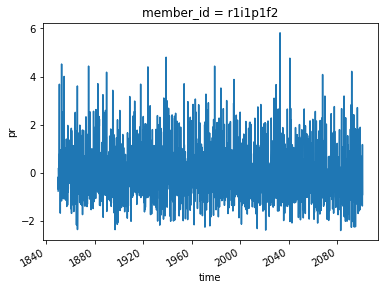

In [52]:
dict_of_ds['CNRM-ESM2-1'].pr[0].plot()